In [497]:
import numpy as np
import torch
from utils import *
features = np.load('locations_small.npy')[1:10, :,:]  # [T,N,D]
features = np.transpose(features, (1, 0, 2))  # [N,T,D]
graphs = np.load('graphs_small.npy') # [T,N,N]
labels = np.load('popularity_small.npy') 

In [498]:
train_feats = torch.FloatTensor(features[:,:features.shape[1]-1,:])
predicted_f = torch.FloatTensor(features[:,1:features.shape[1],:])
train_graphs = torch.FloatTensor(graphs)
mask_feats = features
for i in range(features.shape[1]-1):
    mask_feats[:,i,:] = mask_node(features[:,i,:], 0.5)
mask_feats = torch.FloatTensor(mask_feats)

In [499]:
import argparse
import copy
import sys
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim


from model import GCN, LinkPredictor, LP_Generator, Adaptive_LP

In [500]:
n_epoch = 400
hidden = 32
embed_size = 10
lr = 0.01
weight_decay = 5e-4
alpha = 0.8
num_gt = 1

In [501]:
model1 = GCN(num_feature=train_feats.shape[2],
            num_hidden=hidden,
            output_size=2)
optimizer1 = optim.Adam(model1.parameters(),
                       lr=lr, weight_decay=weight_decay)


model4 = Adaptive_LP(num_feats =train_feats.shape[0], num_hidden =10)
optimizer4 = optim.Adam(model4.parameters(),lr = lr, weight_decay = weight_decay)

model2 = GCN(num_feature=train_feats.shape[2],
            num_hidden=hidden,
            output_size=2)
optimizer2 = optim.Adam(model2.parameters(),
                       lr=lr, weight_decay=weight_decay)

# model3 = LinkPredictor(num_hidden = first_features.shape[1])
# optimizer3 = optim.Adam(model3.parameters(),lr = lr, weight_decay = weight_decay)


In [502]:
for epoch in range(1, n_epoch+1):
    if epoch > 200:
        model1.train()
        optimizer1.zero_grad()
        model4.train()
        optimizer4.zero_grad()
        model2.train()
        optimizer2.zero_grad()
        total_loss = 0
        for t in range(train_feats.shape[1]):
            temp_graph = train_graphs[t:t+1,:,:].reshape(train_feats.shape[0],train_feats.shape[0])
            temp_feats = train_feats[:,t:t+1,:].reshape(-1,train_feats.shape[2])
            temp_mask_feats = mask_feats[:,t:t+1,:].reshape(-1,train_feats.shape[2])
            temp_predicted_feats = predicted_f[:,t:t+1,:].reshape(-1,train_feats.shape[2])
        
#             random_index = random.sample(range(len(adj.reshape(-1))) , int(train_feats.shape[0]*num_gt))
  
            adj = model4()
#             s_loss = torch.nn.BCELoss()
#             structure_l = s_loss(adj.reshape(-1)[random_index], temp_graph.reshape(-1)[random_index])


            pred = model1(temp_feats,adj)
            mask_pred = model2(temp_mask_feats,adj)

            mse_loss = F.mse_loss(pred.squeeze(), temp_predicted_feats.squeeze())
            mask_loss = F.mse_loss(mask_pred.squeeze(), temp_feats.squeeze())

            total_loss += mse_loss + mask_loss # + structure_l
        total_loss.backward()
        optimizer4.step()
        optimizer1.step()
        optimizer2.step()

#         print('Epoch: {:04d}'.format(epoch),
#                   'loss_train: {:.4f}'.format(mse_loss.item()))
    else:
        model4.train()
        optimizer4.zero_grad()
        total_loss = 0
        for t in range(train_feats.shape[1]):
            temp_graph = train_graphs[t:t+1,:,:].reshape(train_feats.shape[0],train_feats.shape[0])
            temp_feats = train_feats[:,t:t+1,:].reshape(-1,train_feats.shape[2])
            temp_mask_feats = mask_feats[:,t:t+1,:].reshape(-1,train_feats.shape[2])
            temp_predicted_feats = predicted_f[:,t:t+1,:].reshape(-1,train_feats.shape[2])

            adj = model4()
            s_loss = torch.nn.BCELoss()
            random_index = random.sample(range(len(adj.reshape(-1))) , int(train_feats.shape[0]*num_gt))

            
            
            structure_l = s_loss(adj.reshape(-1)[random_index], temp_graph.reshape(-1)[random_index])
            
            total_loss += structure_l
        total_loss.backward()
        optimizer4.step()
#         print('Epoch: {:04d}'.format(epoch),
#               'loss_train: {:.4f}'.format(total_loss.item()))
        

g = (adj>0.25).float()

correct = (g.reshape(-1) == temp_graph.reshape(-1)).float().sum()
print('loss_train: {:.4f}'.format(correct/g.reshape(-1).shape[0]))
print('rmse: {:.4f}'.format(mse_loss))

        

loss_train: 0.8816
rmse: 1.0387


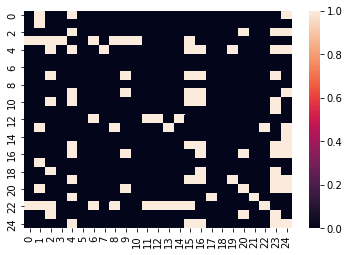

In [503]:
import seaborn as sns
ax = sns.heatmap(adj.detach().numpy()>0.1)

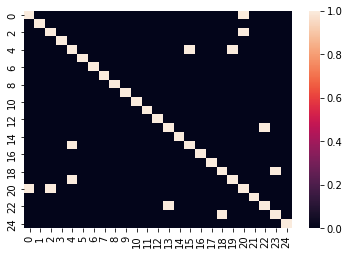

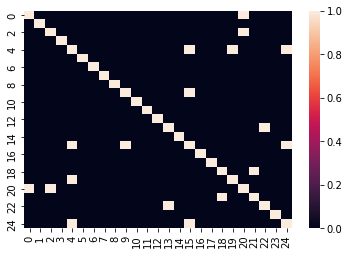

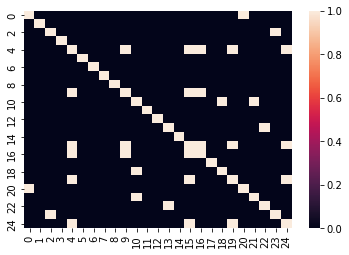

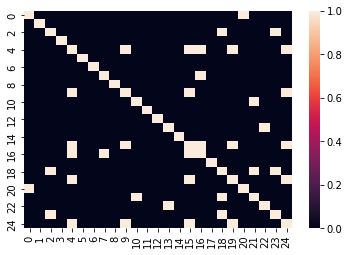

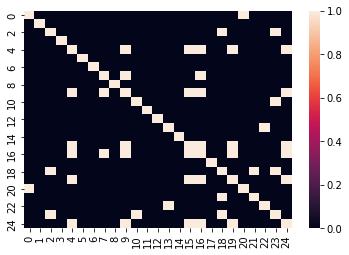

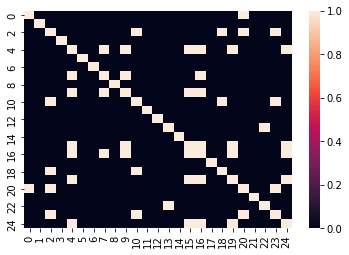

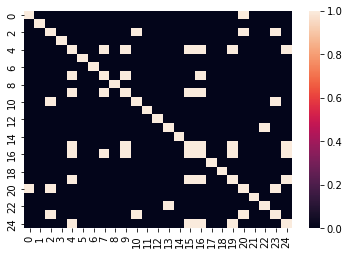

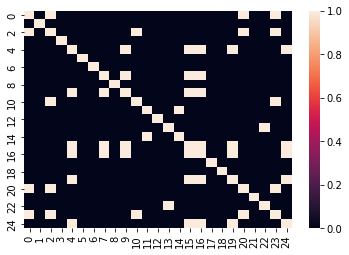

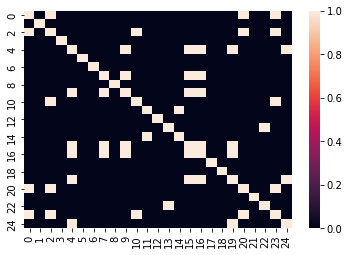

In [504]:
import seaborn as sns
import matplotlib.pylab as plt
for i in range(9):
    sns.heatmap(train_graphs[i:i+1,:,:].reshape(train_feats.shape[0],train_feats.shape[0]))
    plt.show()

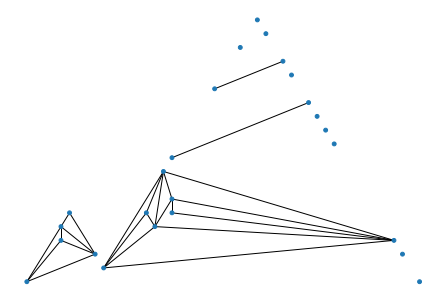

In [505]:
import networkx as nx
truth = train_graphs[i:i+1,:,:].reshape(train_feats.shape[0],train_feats.shape[0])
G = nx.from_numpy_array(truth.detach().numpy())

pos = nx.planar_layout(G)
nx.draw(G, node_size=[15 for (node, val) in G.degree()], pos = pos )

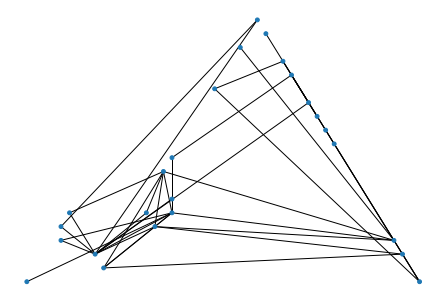

In [511]:
g = (adj>0.2).float()
G = nx.from_numpy_array(g.numpy())
nx.draw(G, node_size=[15 for (node, val) in G.degree()], pos = pos )